## Plot sleep of animals after 6X training protocols or no training protocol

In [1]:
library(scopr)
library(ggplot2)
library(data.table)
library(ggprism)
library(ggetho)

theme_set(ggprism::theme_prism(base_size=25))
parse_interval <- function(intervals, idx) {
    
    x <-  sapply(intervals, function(interval) {
        interval_zt <- unlist(strsplit(interval, split="-"))[[idx]]
        out <- as.numeric(gsub(x=interval_zt, pattern="ZT", replacement=""))
        return(out)
    })
    return(x)
}

Loading required package: behavr
Loading required package: data.table


In [2]:
database <- "idoc_metadata.ods"
readODS::list_ods_sheets(database)

[1] "20min_STM"      "1hr_STM"        "3hr_STM"        "24hr_LTM"      
[5] "24hr_LTM_GTACR"

In [3]:
metadata_ltm <- data.table::as.data.table(readODS::read_ods(database, sheet="24hr_LTM"))[, .(Files, ROI, User, region_id, date, machine_name, Genotype, Incubator, Training,  reference_hour, interactor, interactor_time_window, experiment)]
# there are iso31 flies in the gtacr dataset so we also load from there
metadata_gtacr <- data.table::as.data.table(readODS::read_ods(database, sheet="24hr_LTM_GTACR"))[, .(Files, ROI, User, region_id, date, machine_name, Genotype, Incubator, Training, reference_hour, interactor, interactor_time_window, experiment)]
metadata <- rbind(metadata_ltm, metadata_gtacr)
metadata <- metadata[!is.na(date),]
metadata <- metadata[Genotype=="Iso31",]
metadata <- metadata[interactor=="DefaultStimulator",]
metadata$Training <- factor(metadata$Training, levels=c("No_training", "6X_Massed", "6X_Spaced"))
metadata[is.na(ROI), ROI := "NONE"]

New names:
• `Counted` -> `Counted...19`
• `Counted` -> `Counted...23`New names:
• `Counted` -> `Counted...19`
• `Counted` -> `Counted...23`

In [4]:
metadata[, interval1:="NONE"]
metadata[, interval2:="NONE"]
metadata[interactor_time_window!="No_stimulator", interval1 := parse_interval(interactor_time_window, 1)]           
metadata[interactor_time_window!="No_stimulator", interval2 := parse_interval(interactor_time_window, 2)]

In [5]:
metadata_linked <- scopr::link_ethoscope_metadata(metadata, result_dir="/ethoscope_data/results")

searching the provided database for data matching query
parsing date and time
processing rows without time
... removing duplicates i.e. no 2 db files will be from same ethoscope and day.
  If more than 1 is found, we keep the last. A warning will be emitted in that case
processing rows with time
copying query
creating path and experiment_id columns


In [6]:
table(metadata_linked$Training)


No_training   6X_Massed   6X_Spaced 
         31          50          51 

In [7]:
dt <- scopr::load_ethoscope(
    metadata_linked,
    verbose=FALSE,
    reference_hour=NA,
    cache="/ethoscope_data/cache",
    FUN=sleepr::sleep_annotation, velocity_correction_coef=0.0048, time_window_length=10, min_time_immobile=300
)

Warning message in FUN(X[[i]], ...):
“ROI 3 from file /ethoscope_data/results/036aad42625f433eb4bd2b44f811738e/ETHOSCOPE_036/2023-07-24_15-17-20/2023-07-24_15-17-20_036aad42625f433eb4bd2b44f811738e.db has no data”

In [8]:
dt_bin <- behavr::bin_apply_all(dt, y="asleep", x_bin_length=behavr::mins(30), summary_FUN=mean)
dt_bin$asleep <- dt_bin$asleep*30

In [9]:
saveRDS(object = dt_bin, file = "dt_bin.RDS")

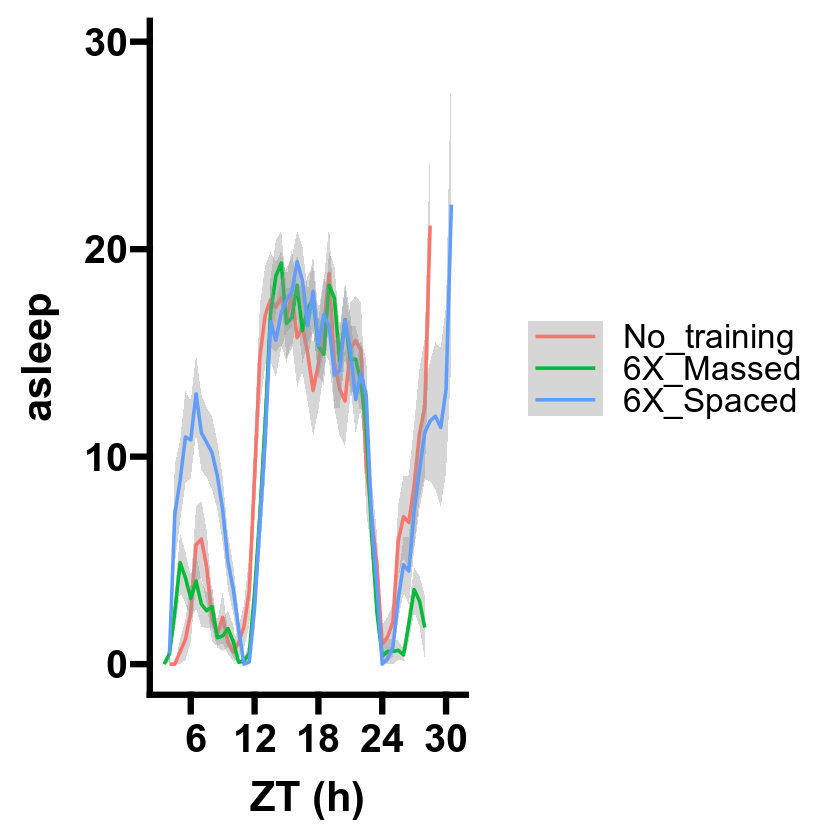

In [10]:
ggplot(data=behavr::rejoin(dt_bin)[Genotype=="Iso31" & interactor=="DefaultStimulator",], aes(x=t, y=asleep, color=Training)) +
    stat_pop_etho() +
    scale_x_hours(name="ZT")
